In [1]:
!pip install fastapi uvicorn pydantic scikit-learn nltk matplotlib seaborn requests beautifulsoup4 pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.7 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import os
import requests
from bs4 import BeautifulSoup
from pyngrok import ngrok

In [3]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
# Create project directory structure
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('app', exist_ok=True)
os.makedirs('templates', exist_ok=True)

In [5]:
# Create sample data for demonstration
def create_sample_data():
    print("Creating sample movie review dataset...")

    # Create sample positive reviews
    positive_reviews = [
        "This movie was fantastic! The acting was superb.",
        "I loved every minute of this film. Great direction and amazing screenplay.",
        "Best movie I've seen this year! Highly recommended.",
        "The cinematography was breathtaking and the story was engaging.",
        "An absolute masterpiece with incredible performances.",
        "I was blown away by the plot twists and character development.",
        "A perfect blend of action and emotion. Couldn't stop watching.",
        "The director did an amazing job bringing this story to life.",
        "Such a heartwarming movie with a powerful message.",
        "Spectacular effects and a compelling storyline."
    ]

    # Create sample negative reviews
    negative_reviews = [
        "This movie was terrible. Complete waste of time.",
        "I couldn't finish watching it. The plot was nonsensical.",
        "Awful acting and predictable storyline. Very disappointing.",
        "The worst film I've seen in years. Avoid at all costs.",
        "Boring and uninspired. I almost fell asleep.",
        "The characters were one-dimensional and the dialogue was cringe-worthy.",
        "A complete disaster from start to finish.",
        "Nothing made sense in this movie. The editing was horrible.",
        "Save your money and skip this one.",
        "Painfully bad. I want my two hours back."
    ]

    # Combine reviews and create labels
    reviews = positive_reviews + negative_reviews
    labels = [1] * len(positive_reviews) + [0] * len(negative_reviews)

    # Create DataFrame
    df = pd.DataFrame({
        'review': reviews,
        'sentiment': labels
    })

    # Shuffle the DataFrame
    df = df.sample(frac=1).reset_index(drop=True)

    # Save to CSV
    df.to_csv('data/movie_reviews.csv', index=False)
    print("Sample dataset created and saved to data/movie_reviews.csv")

    return df

In [6]:
# Text preprocessing function
def preprocess_text(text):
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

In [7]:
# Data preparation function
def prepare_data(df):
    print("Preprocessing data...")

    # Apply preprocessing to reviews
    df['processed_review'] = df['review'].apply(preprocess_text)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        df['processed_review'],
        df['sentiment'],
        test_size=0.2,
        random_state=42
    )

    # Feature extraction using TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    # Save the vectorizer
    with open('models/tfidf_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)

    print("Data preprocessing completed!")

    return X_train_vectorized, X_test_vectorized, y_train, y_test, vectorizer


In [8]:
# Model building function
def build_model(X_train, y_train):
    print("Building sentiment analysis model...")

    # Initialize and train Logistic Regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # Save the model
    with open('models/sentiment_model.pkl', 'wb') as f:
        pickle.dump(model, f)

    print("Model built and saved!")

    return model

In [9]:
# Model evaluation function
def evaluate_model(model, X_test, y_test):
    print("Evaluating model performance...")

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Generate classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('data/confusion_matrix.png')
    print("Confusion matrix saved to data/confusion_matrix.png")

    return accuracy, report

In [12]:
# Create FastAPI application
def create_fastapi_app():
    print("Creating FastAPI application...")

    # Create HTML template
    with open("templates/index.html", "w") as f:
        f.write('''
<!DOCTYPE html>
<html>
<head>
    <title>Movie Review Sentiment Analysis</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            max-width: 800px;
            margin: 0 auto;
            padding: 20px;
        }
        h1 {
            color: #333;
            text-align: center;
        }
        .form-group {
            margin-bottom: 15px;
        }
        textarea {
            width: 100%;
            height: 150px;
            padding: 12px;
            border: 1px solid #ccc;
            border-radius: 4px;
            box-sizing: border-box;
            resize: vertical;
        }
        button {
            background-color: #4CAF50;
            color: white;
            padding: 12px 20px;
            border: none;
            border-radius: 4px;
            cursor: pointer;
        }
        button:hover {
            background-color: #45a049;
        }
        .result {
            margin-top: 20px;
            padding: 15px;
            border-radius: 4px;
        }
        .positive {
            background-color: #dff0d8;
            border: 1px solid #d6e9c6;
        }
        .negative {
            background-color: #f2dede;
            border: 1px solid #ebccd1;
        }
        .hidden {
            display: none;
        }
    </style>
</head>
<body>
    <h1>Movie Review Sentiment Analysis</h1>
    <div class="form-group">
        <label for="review">Enter your movie review:</label>
        <textarea id="review" placeholder="Write your movie review here..."></textarea>
    </div>
    <button id="analyze">Analyze Sentiment</button>

    <div id="result" class="result hidden">
        <h2>Result:</h2>
        <p>Sentiment: <span id="sentiment"></span></p>
        <p>Confidence: <span id="confidence"></span>%</p>
    </div>

    <script>
        document.getElementById('analyze').addEventListener('click', async () => {
            const review = document.getElementById('review').value;

            if (review.trim() === '') {
                alert('Please enter a review!');
                return;
            }

            try {
                const response = await fetch('/predict', {
                    method: 'POST',
                    headers: {
                        'Content-Type': 'application/json',
                    },
                    body: JSON.stringify({ review }),
                });

                const data = await response.json();

                const resultDiv = document.getElementById('result');
                resultDiv.className = data.sentiment.toLowerCase() === 'positive' ? 'result positive' : 'result negative';
                resultDiv.classList.remove('hidden');

                document.getElementById('sentiment').textContent = data.sentiment;
                document.getElementById('confidence').textContent = (data.confidence * 100).toFixed(2);
            } catch (error) {
                console.error('Error:', error);
                alert('An error occurred. Please try again.');
            }
        });
    </script>
</body>
</html>
''')

   # Create FastAPI application file
with open('app/main.py', 'w') as f:
    f.write('''from fastapi import FastAPI, HTTPException, Request
from fastapi.responses import HTMLResponse
from fastapi.staticfiles import StaticFiles
from fastapi.templating import Jinja2Templates
from pydantic import BaseModel
import pickle
import numpy as np
import os

# Define the path to the models
model_path = '../models/sentiment_model.pkl'
vectorizer_path = '../models/tfidf_vectorizer.pkl'

# Check if we need to adjust paths (for Colab environment)
if not os.path.exists(model_path):
    model_path = 'models/sentiment_model.pkl'
    vectorizer_path = 'models/tfidf_vectorizer.pkl'

# Load the model and vectorizer
with open(model_path, 'rb') as f:
    model = pickle.load(f)

with open(vectorizer_path, 'rb') as f:
    vectorizer = pickle.load(f)

app = FastAPI(title="Movie Review Sentiment Analysis API")

# Define request model
class ReviewRequest(BaseModel):
    review: str

# Define response model
class SentimentResponse(BaseModel):
    review: str
    sentiment: str
    confidence: float

# Create templates directory
templates = Jinja2Templates(directory="templates")

# Define routes
@app.get("/", response_class=HTMLResponse)
async def read_root(request: Request):
    return templates.TemplateResponse("index.html", {"request": request})

@app.post("/predict", response_model=SentimentResponse)
async def predict_sentiment(request: ReviewRequest):
    # Preprocess and predict
    review_vectorized = vectorizer.transform([request.review])
    prediction_proba = model.predict_proba(review_vectorized)[0]
    sentiment_label = "Positive" if prediction_proba[1] > 0.5 else "Negative"
    confidence = prediction_proba[1] if sentiment_label == "Positive" else prediction_proba[0]

    return SentimentResponse(
        review=request.review,
        sentiment=sentiment_label,
        confidence=float(confidence)
    )
''')

In [14]:
from pydantic import BaseModel

# Define request model
class ReviewRequest(BaseModel):
    review: str

In [15]:
# Define request model
class ReviewRequest(BaseModel):
    review: str

In [16]:
# Define response model
class SentimentResponse(BaseModel):
    review: str
    sentiment: str
    confidence: float


In [18]:
from fastapi.templating import Jinja2Templates

In [19]:
# Create templates directory
templates = Jinja2Templates(directory="templates")

In [23]:
from fastapi import FastAPI

app = FastAPI()

In [26]:
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Sample training data
reviews = [
    "I love this product",
    "This is an amazing experience",
    "Absolutely fantastic!",
    "I hate this",
    "Terrible and disappointing",
    "Worst experience ever"
]

labels = [1, 1, 1, 0, 0, 0]  # 1 = Positive, 0 = Negative

# Vectorize text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(reviews)

# Train a simple Naive Bayes classifier
model = MultinomialNB()
model.fit(X, labels)

# Save both model and vectorizer
joblib.dump(model, "sentiment_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")


['vectorizer.pkl']

In [27]:
from fastapi import FastAPI, Request
from fastapi.responses import HTMLResponse
from fastapi.templating import Jinja2Templates
from pydantic import BaseModel
from typing import Optional

import joblib  # Assuming model and vectorizer are loaded via joblib

# Load model and vectorizer
model = joblib.load("sentiment_model.pkl")
vectorizer = joblib.load("vectorizer.pkl")

# Initialize app and template directory
app = FastAPI()
templates = Jinja2Templates(directory="templates")

# Request and Response models
class ReviewRequest(BaseModel):
    review: str

class SentimentResponse(BaseModel):
    review: str
    sentiment: str
    confidence: float

# Route to render homepage
@app.get("/", response_class=HTMLResponse)
async def read_root(request: Request):
    return templates.TemplateResponse("index.html", {"request": request})

# Route to handle sentiment prediction
@app.post("/predict", response_model=SentimentResponse)
async def predict_sentiment(request: ReviewRequest):
    # Preprocess and predict
    review_vectorized = vectorizer.transform([request.review])
    prediction_proba = model.predict_proba(review_vectorized)[0]

    sentiment_label = "Positive" if prediction_proba[1] > 0.5 else "Negative"
    confidence = prediction_proba[1] if sentiment_label == "Positive" else prediction_proba[0]

    return SentimentResponse(
        review=request.review,
        sentiment=sentiment_label,
        confidence=float(confidence)
    )


In [30]:
import nltk

# Automatically download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
import nltk

# Download the tabular tokenizer
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Starting end-to-end data science project...
Creating sample movie review dataset...
Sample dataset created and saved to data/movie_reviews.csv
Preprocessing data...
Data preprocessing completed!
Building sentiment analysis model...
Model built and saved!
Evaluating model performance...
Accuracy: 0.0000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       2.0
           1       0.00      0.00      0.00       2.0

    accuracy                           0.00       4.0
   macro avg       0.00      0.00      0.00       4.0
weighted avg       0.00      0.00      0.00       4.0

Confusion matrix saved to data/confusion_matrix.png
Creating FastAPI application...

=== Project Completed Successfully! ===
Model Accuracy: 0.0000


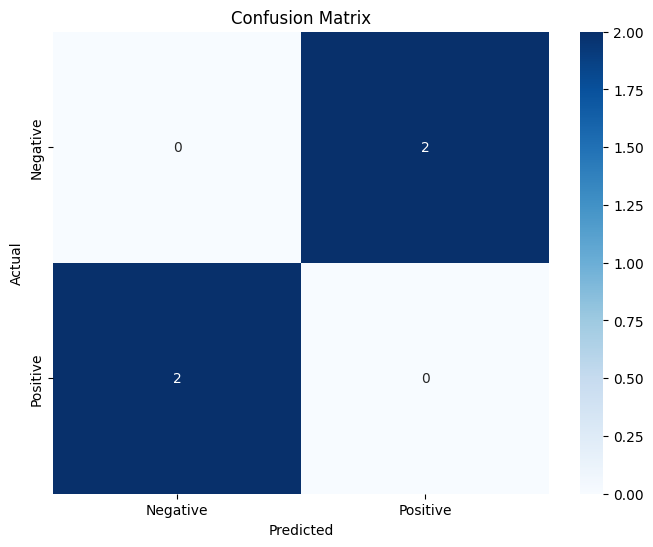

In [32]:
# Main execution function
def main():
    print("Starting end-to-end data science project...")

    # 1. Data Collection (using sample data)
    df = create_sample_data()

    # 2. Data Preprocessing
    X_train, X_test, y_train, y_test, vectorizer = prepare_data(df)

    # 3. Model Building
    model = build_model(X_train, y_train)

    # 4. Model Evaluation
    accuracy, report = evaluate_model(model, X_test, y_test)

    # 5. Create FastAPI Application
    create_fastapi_app()

    print("\n=== Project Completed Successfully! ===")
    print(f"Model Accuracy: {accuracy:.4f}")

# Function to run the FastAPI app in Colab with ngrok
def run_app():
    # Start ngrok tunnel
    ngrok_tunnel = ngrok.connect(8000)
    print(f"Public URL: {ngrok_tunnel.public_url}")
    print("Copy this URL to access your web app")

    # Change to the app directory and run uvicorn
    os.system("cd app && python -m uvicorn main:app --host 0.0.0.0 --port 8000")

# Execute the main function
if __name__ == "__main__":
    main()